In [1]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.utils.ensemble import sorted_neurons
from nengo.utils.matplotlib import rasterplot

# Transformations
from neuroptimiser.utils import tro2s, trs2o

from ioh import get_problem


In [45]:

PROBLEM_ID      = 1  # Problem ID from the IOH framework
PROBLEM_INS     = 1  # Problem instance
NUM_DIMENSIONS  = 2  # Number of dimensions for the problem

problem         = get_problem(fid=PROBLEM_ID, instance=PROBLEM_INS, dimension=NUM_DIMENSIONS)
problem.reset()
print(problem)

X_LOWER_BOUND   = problem.bounds.lb
X_UPPER_BOUND   = problem.bounds.ub
X_INITIAL_GUESS = np.random.uniform(X_LOWER_BOUND, X_UPPER_BOUND, NUM_DIMENSIONS)


<RealSingleObjectiveProblem 1. Sphere (iid=1 dim=2)>


In [55]:

# Create the Nengo model
model = nengo.Network(label="nNeurOpti V1", seed=69)
with model:
    # INITIALISATION
    # --------------------------------------------------------------
    # v0_state    = tro2s(X_INITIAL_GUESS, X_LOWER_BOUND, X_UPPER_BOUND)
    # Input nodes for the bounds and initial guess
    # input_x_l    = nengo.Node(label="x_l", output=X_LOWER_BOUND)
    # input_x_u    = nengo.Node(label="x_u", output=X_UPPER_BOUND)
    # input_x_0    = nengo.Node(label="x_0", output=X_INITIAL_GUESS)

    # LOCAL STATE
    state = {
        "best_v": None, #v0_state.copy(),
        "best_f": np.inf, #f_obj(None, v0_state),
    }

    # State ensemble
    n_neurons   = 50 * NUM_DIMENSIONS
    ens_lif     = nengo.Ensemble(
        label       = "ens_lif",
        n_neurons   = n_neurons,
        dimensions  = NUM_DIMENSIONS,
        radius      = 1.0,
        # intercepts  = nengo.dists.Uniform(-0.9, 0.9),
        # max_rates   = nengo.dists.Uniform(80,220),
        # encoders    = nengo.dists.UniformHypersphere(surface=True),
        neuron_type = nengo.LIF(
            # initial_state   = {
            #     "voltage": nengo.dists.Uniform(-1.0, 1.0),
            #     "refractory_time": np.zeros(n_neurons)
            # },
            # min_voltage     = -1.0,
        ),
        # noise=nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.5), seed=42),
    )

    # Recurrent connection to hold the state
    eta = 1.0 # "Learning rate"
    def hs(x):
        if state["best_v"] is None:
            return np.zeros_like(x)
        else:
            best_v      = state["best_v"]
            return eta * (best_v - x)
            # return x + eta * (best_v - x) + np.random.normal(0, 0.1, size=x.shape)  # Add some noise for exploration

    tau     = 0.05
    nengo.Connection(
        label       = "recurrent",
        pre         = ens_lif,
        post        = ens_lif,
        synapse     = tau,
        function    = hs,
        transform   = np.eye(NUM_DIMENSIONS),
    )

    # Encoding function for the initial guess in state space within [-1, 1]
    # input_v0    = nengo.Node(label="v0_state", output=v0_state.copy())

    # nengo.Connection(input_v0, ens_lif, synapse=None)


    # Evaluate the objective function
    def f_obj(t, state_vector):
        """Evaluate the objective function at the given state vector."""
        v       = np.clip(state_vector, -1.0, 1.0)  # Ensure within bounds, consider toroidal space later
        x_vals  = trs2o(v, X_LOWER_BOUND, X_UPPER_BOUND)
        # Implement here the transformation for integer variables if needed
        fv      = problem(x_vals)
        return np.concatenate((v, [fv]))

    # Connect to the objective function node
    obj_node    = nengo.Node(
        label="f_obj",
        output=f_obj,
        size_in=NUM_DIMENSIONS,
        size_out=NUM_DIMENSIONS+1
    )
    nengo.Connection(ens_lif, obj_node, synapse=0)

    # ====
    def local_selector(t, x):
        v       = x[:NUM_DIMENSIONS]
        fv      = float(x[NUM_DIMENSIONS])
        if state["best_f"] is None or (fv < state["best_f"] and t >= 0.01):  # Avoid initial transient
            state["best_f"] = fv
            state["best_v"] = v.copy()

        if state["best_v"] is None:
            return np.concatenate((v, [fv]))
        else:
            return np.concatenate((state["best_v"], [state["best_f"]]))

    selector_node   = nengo.Node(
        label="local_best",
        output=local_selector,
        size_in=NUM_DIMENSIONS + 1,
        size_out=NUM_DIMENSIONS + 1,
    )
    nengo.Connection(obj_node, selector_node, synapse=0)
    # ====

    # Controller towards the best-so-far
    # eta = 0.2 # Learning rate or movement rate towards the best
    # def controller(t, x):
    #     best_v  = x[:NUM_DIMENSIONS]
    #     curr_v  = x[NUM_DIMENSIONS:]
    #     return eta * (best_v - curr_v)

    # control_node = nengo.Node(
    #     label="controller",
    #     output=controller,
    #     size_in=2 * NUM_DIMENSIONS,
    #     size_out=NUM_DIMENSIONS,
    # )

    # nengo.Connection(selector_node[:NUM_DIMENSIONS], control_node[:NUM_DIMENSIONS], synapse=0)
    # nengo.Connection(ens_lif, control_node[NUM_DIMENSIONS:], synapse=0)      # Current state vector

    # nengo.Connection(control_node, ens_lif, synapse=0.01)  # Apply control to the ensemble

    fbest_only = nengo.Node(
        size_in=NUM_DIMENSIONS+1,
        size_out=1,
        output=lambda t, x: x[-1]
    )
    nengo.Connection(selector_node, fbest_only, synapse=0)

    # input_probe = nengo.Probe(v_0, synapse=0.01)
    ens_lif_val = nengo.Probe(ens_lif, synapse=0.01)  # 10ms filter
    obj_val     = nengo.Probe(obj_node, synapse=0.01)
    fbest_val   = nengo.Probe(fbest_only, synapse=0.01)
    ens_lif_spk = nengo.Probe(ens_lif.neurons)  # Collect the spikes


In [56]:
simulation_time = 10.0  # seconds

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(simulation_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

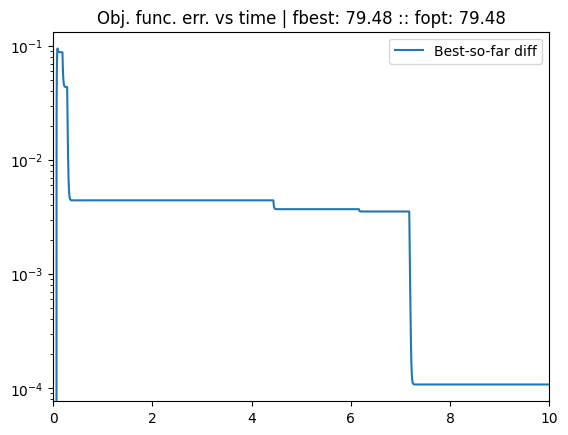

In [57]:
plt.figure()
# plt.plot(sim.trange(), sim.data[obj_val], label="Objective value")
plt.plot(sim.trange(), sim.data[fbest_val] - problem.optimum.y, label="Best-so-far diff") #"Best-so-far value")
# plt.hlines(problem.optimum.y, 0, simulation_time, colors="r", linestyles="dashed", label="Optimal value")
plt.xlim(0, simulation_time)
plt.yscale("log")
plt.legend()
plt.title(f"Obj. func. err. vs time | fbest: {sim.data[fbest_val][-1][0]:.2f} :: fopt: {problem.optimum.y}")
plt.show()

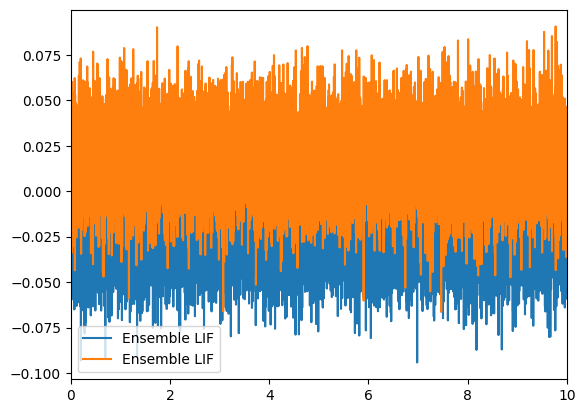

In [58]:
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[ens_lif_val], label="Ensemble LIF")
# plt.plot(sim.trange(), sim.data[input_probe], "r", label="Input")
plt.xlim(0, simulation_time)
plt.legend()
plt.show()

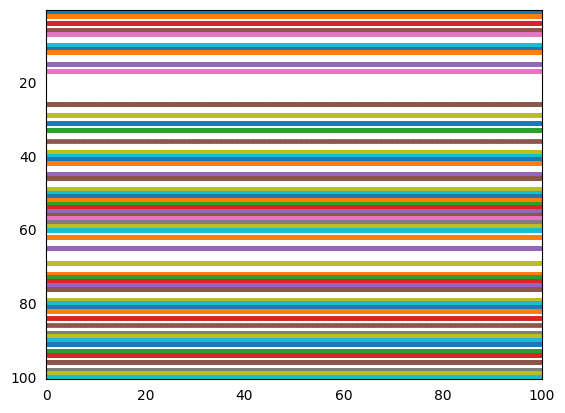

In [54]:
# Plot the spiking output of the ensemble
plt.figure()
rasterplot(sim.trange(), sim.data[ens_lif_spk])
plt.xlim(0, simulation_time)
plt.show()


In [32]:
# # For interest's sake, you can also sort by encoder
# indices = sorted_neurons(ens_lif, sim, iterations=250)
# plt.figure()
# rasterplot(sim.trange(), sim.data[ens_lif_spk][:, indices])
# plt.xlim(0, simulation_time)
# plt.show()